<center><img src="assets/header.png" width="25%" style="border-radius:20px;" /></center>

# Intro

We are Gal Elharar (207906553) and Roy Wolfer (324074566), computer science students with a strong passion for data science and its applications in healthcare.  
For our semester project, we sought to tackle a meaningful challenge while expanding our skill set.  
After exploring Kaggle competitions, we were immediately drawn to the [Equity in post-HCT Survival Predictions](https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions) challenge.

This competition focuses on predicting survival probabilities for patients undergoing hematopoietic cell transplantation (HCT),  
with an emphasis on ensuring equitable outcomes across different racial groups.  
The evaluation metric used in this challenge is the Stratified Concordance Index (C-index),  
which adjusts for racial stratification to promote fairness and equity in the predictions.  
This makes the challenge particularly impactful in addressing disparities in healthcare outcomes.

We are excited to dive into this project, combining our data science skills with our interest in advancing equity in medicine.

### The problem

We couldn’t explain the problem any better as it was outlined in the kaggle challenge description:

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge.  
Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography.  
Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

This competition aims to encourage participants to advance predictive modeling by ensuring that survival predictions are both precise and fair for patients across diverse groups.  
By using synthetic data, which mirrors real-world situations while protecting patient privacy, participants can build and improve models that more effectively consider diverse backgrounds and conditions.

You’re challenged to develop advanced predictive models for allogeneic HCT that enhance both accuracy and fairness in survival predictions.  
The goal is to address disparities by bridging diverse data sources, refining algorithms, and reducing biases to ensure equitable outcomes for patients across diverse race groups.  
Your work will help create a more just and effective healthcare environment, ensuring every patient receives the care they deserve.

### Risk Score

In this challenge, survival predictions are expressed as **risk scores**, representing the likelihood of an adverse event (death, relapse, rejection, or moderate to severe GVHD) within a specific timeframe after hematopoietic cell transplantation (HCT). Higher scores indicate a higher likelihood of an adverse event and shorter survival time, while lower scores suggest a lower probability and longer survival time.

**Stratification for Fairness:**

Risk scores are stratified by racial group to ensure fair and unbiased predictions across diverse patient populations. This is critical for equitable healthcare applications.

**Clinical Implications:**

These risk scores can guide clinical decision-making by identifying patients at higher risk, enabling personalized follow-up and care to improve outcomes and reduce disparities.

# EDA

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
import xgboost
import catboost
import warnings
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from scipy.stats import rankdata
from itables import show
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, quantile_transform
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

### Reading the data

We read the data and observe:
1. The training dataset has 59 columns, many of which are categorical and have missing values.
2. Two columns are missing from the test dataset: `efs` and `efs_time`. These two columns together make up the target.

In [2]:
train = pd.read_csv('datasets/train.csv', index_col='ID')
test = pd.read_csv('datasets/test.csv', index_col='ID')
data_dictionary = pd.read_csv('datasets/data_dictionary.csv')
train.tail()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
ID,,,,,,,,,,,,,,,,,,,,,
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,Bi-directional non-permissive,NaN,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,18.633
28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,5.0,Peripheral blood,...,GvH non-permissive,Related,"N/A, Mel not given",6.0,Yes,1.0,Yes,8.0,1.0,4.892
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,6.0,Peripheral blood,...,GvH non-permissive,Unrelated,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,23.157
28798,N/A - non-malignant indication,No,Poor,No,1.0,4.0,No TBI,No,3.0,Peripheral blood,...,Permissive mismatched,Related,MEL,4.0,No,1.0,No,5.0,0.0,52.351
28799,N/A - pediatric,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,Permissive mismatched,Related,MEL,8.0,No,2.0,Yes,10.0,0.0,25.158


In [3]:
features = [f for f in test.columns if f != 'ID']

race_groups = np.unique(train.race_group)

### The data dictionary

The data dictionary simply describes the 59 columns of the dataset:

In [4]:
show(data_dictionary, scrollY="400px", scrollCollapse=True, paging=False, classes="display compact", columnDefs=[{"className": "dt-left", "targets": "_all"}], layout={"topStart": "search", "topEnd": None})

### The prediction target

The prediction target consists of two parts:
1. `efs_time`, always positive, is a time, measured in months.
2. `efs`, always zero or one, indicates the presence or absence of an event:
   - `efs=1` means "patient was without event for **exactly** `efs_time`.
   - `efs=0` means "patient was without event for **at least** `efs_time`"

This situation is called "censored data": Samples of which we know the time of event are uncensored, and if we only know a lower bound for the time of event, the sample is (right-)censored.

**Censoring is the main reason that this competition has a special metric and that we need special models.**  
The competition is a regression task, but we know y_true for only half the samples.  
For the other (censored) half, all we know is lower bounds for y_true.  
One cannot compute a squared error based on `y_true > 100 and y_pred == 120`. RMSE and similar metrics cannot deal with that.

A histogram of the target values shows that half the patients have an event within 20 months after the transplantation.  
The other half, without event for the first 20 months, has a high probability of not having an event for much longer.

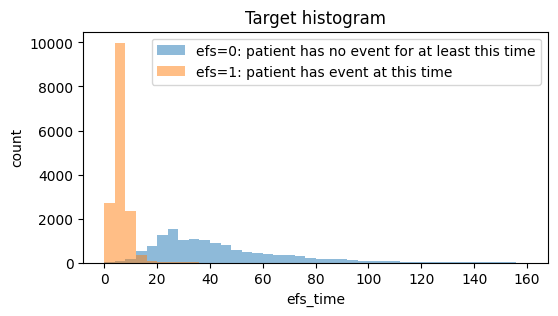

In [5]:
plt.figure(figsize=(6, 3))
plt.hist(train.efs_time[train.efs == 0], bins=np.linspace(0, 160, 41), label='efs=0: patient has no event for at least this time', alpha=0.5)
plt.hist(train.efs_time[train.efs == 1], bins=np.linspace(0, 160, 41), label='efs=1: patient has event at this time', alpha=0.5)
plt.legend()
plt.xlabel('efs_time')
plt.ylabel('count')
plt.title('Target histogram')
plt.show()

### Missing values
Because we are dealing with medical data, in order to protect patient privacy, some data is censored.  
Oftentimes, medical data can also be incomplete due to not being measured for all cases.

Both of these things can contribute to missing values in the dataset, that we will have to deal with during our research.  
First, we will find out which features have missing values.

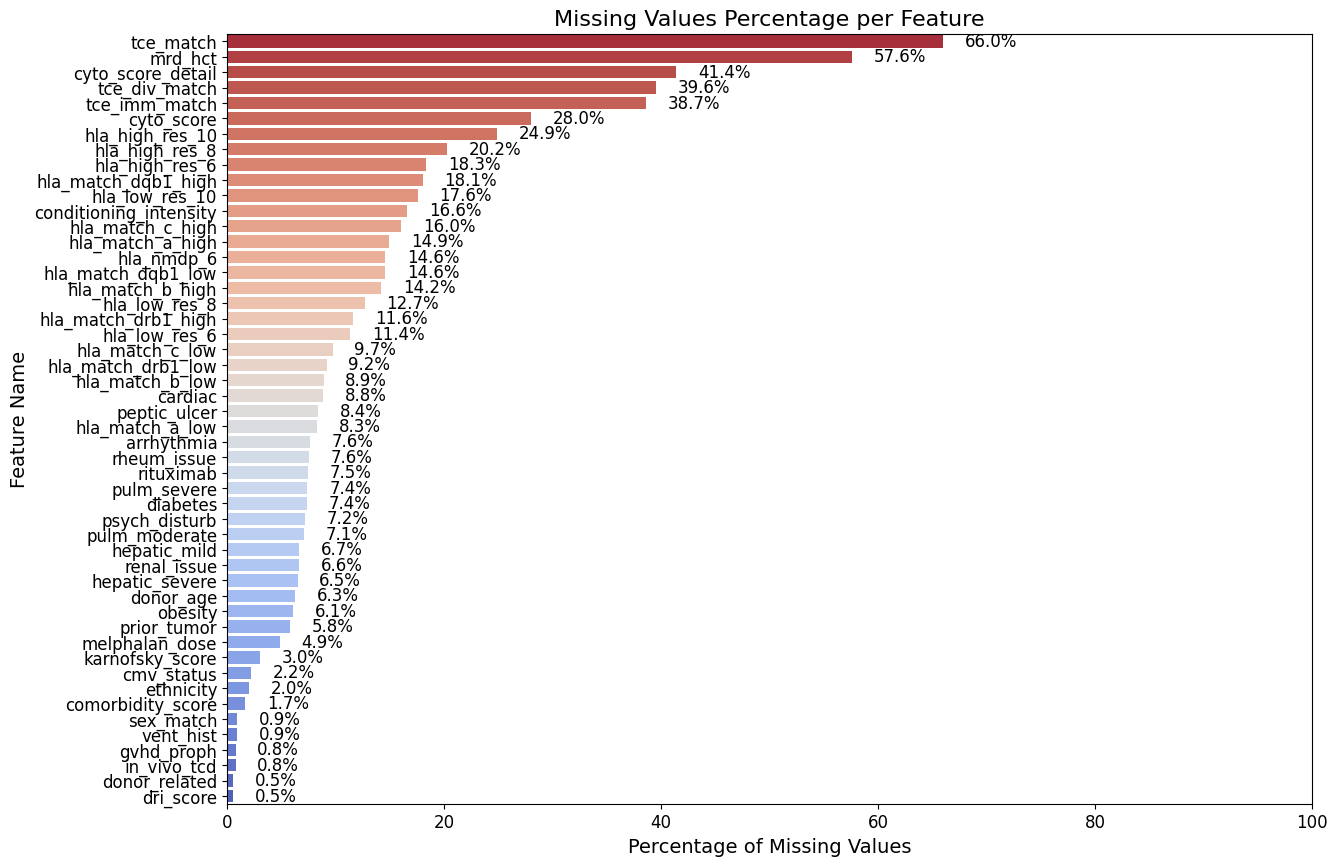

In [6]:
# Calculate missing values percentage
missing_values = train.isnull().sum() / len(train) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Generate a color gradient from dark blue (low missing) to red (high missing)
colors = sns.color_palette("coolwarm", len(missing_values))[::-1]

# Plot missing values with updated formatting
plt.figure(figsize=(14, 10))
bars = sns.barplot(y=missing_values.index, x=missing_values.values, palette=colors, hue=missing_values.index)

# Set x-axis to always go up to 100%
plt.xlim(0, 100)

# Labels and title
plt.xlabel("Percentage of Missing Values", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.title("Missing Values Percentage per Feature", fontsize=16)

# Rotate x-axis ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

# Annotate each bar with its missing percentage
for bar, value in zip(bars.patches, missing_values.values):
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
             f"{value:.1f}%", ha='left', va='center', fontsize=12, color='black')

plt.show()

As we can see, a significant amount of features contain missing data.  
With some containing more than 50% missing values!

What should we do?

We have three options:
1. Fill in (impute) the missing values using the mean, median, or mode.
2. Drop the feature if it’s mostly empty.
3. Treat missing values as a separate category - sometimes missing data itself carries meaning!

For now, at least for the categorical features, we choose the third option.

In [7]:
cat_features = list(train.select_dtypes(object).columns)
train[cat_features] = train[cat_features].astype(str).astype('category')

Let's review the missing values now.

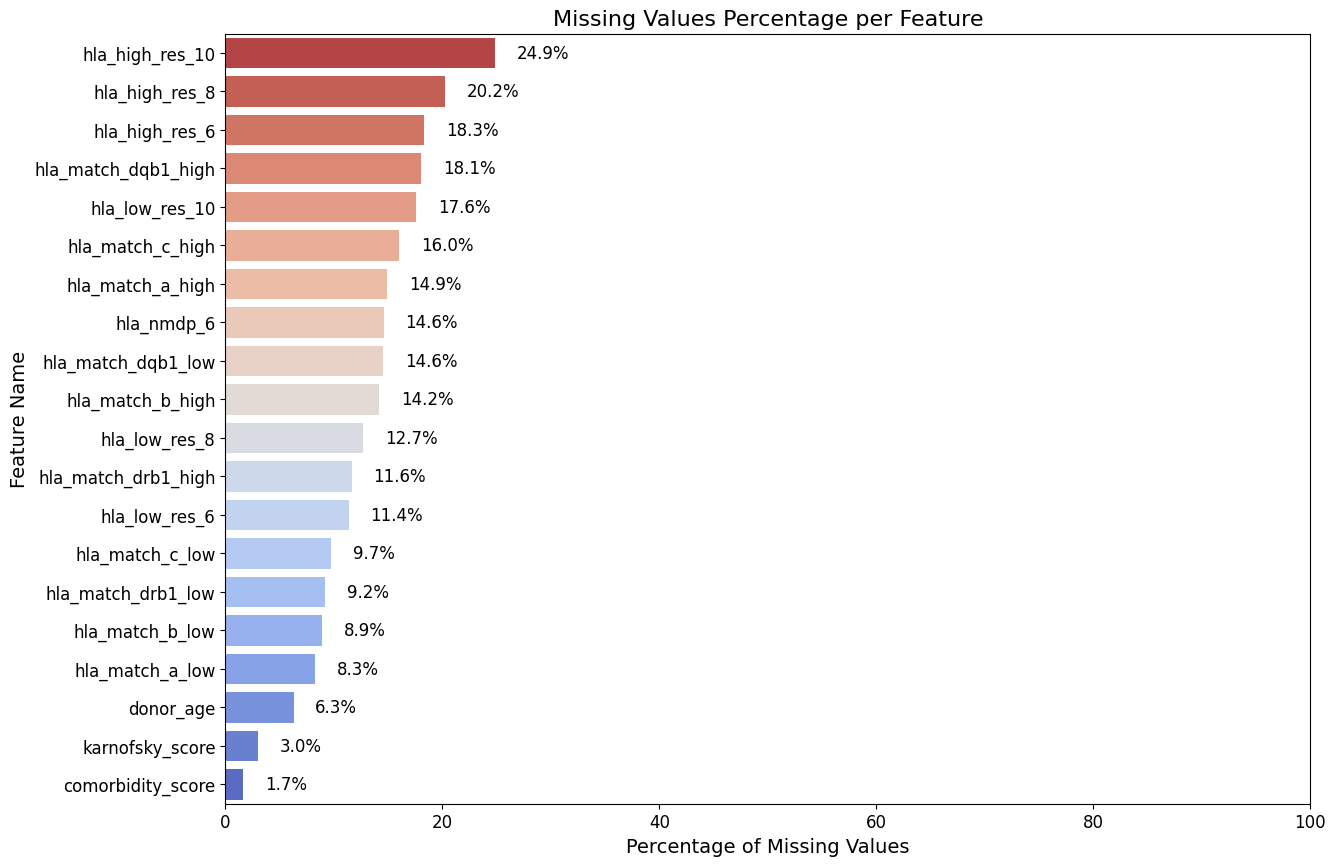

In [8]:
# Calculate missing values percentage
missing_values = train.isnull().sum() / len(train) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Generate a color gradient from dark blue (low missing) to red (high missing)
colors = sns.color_palette("coolwarm", len(missing_values))[::-1]

# Plot missing values with updated formatting
plt.figure(figsize=(14, 10))
bars = sns.barplot(y=missing_values.index, x=missing_values.values, palette=colors, hue=missing_values.index)

# Set x-axis to always go up to 100%
plt.xlim(0, 100)

# Labels and title
plt.xlabel("Percentage of Missing Values", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.title("Missing Values Percentage per Feature", fontsize=16)

# Rotate x-axis ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

# Annotate each bar with its missing percentage
for bar, value in zip(bars.patches, missing_values.values):
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
             f"{value:.1f}%", ha='left', va='center', fontsize=12, color='black')

plt.show()

Much better!  
Now our models will be able to handle missing values for categorical features.

### Synthetic data artifacts

As pointed out in the problem description, the data used in the training dataset is synthetic, in order to "*mirror real-world situations while protecting patient privacy*".  
This is with the goal to help us "*build and improve models that more effectively consider diverse backgrounds and conditions*".

But as we will see, the data has some clear data generation artifacts, that prevent it from actually mirroring real-world situations.


##### Race group distribution
In the training data, there are six race groups with about 4800 samples each.  
Because in no country of the world these six race groups occur with equal frequencies, we know that some of the groups have been upsampled or downsampled in the dataset.

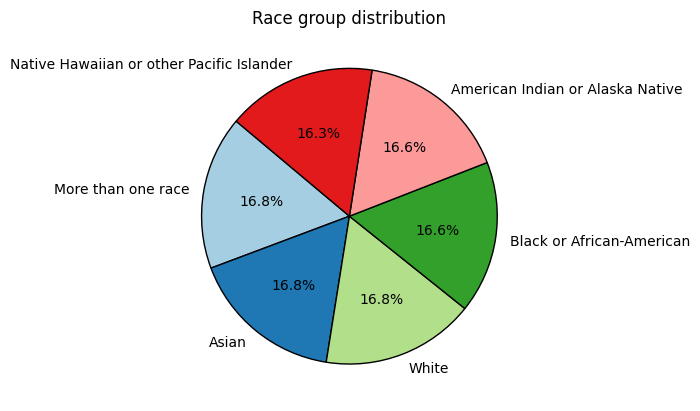

In [9]:
race_counts = train.race_group.value_counts()

plt.pie(race_counts.values, labels=race_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'})

plt.title('Race group distribution')
plt.show()

##### Patient age distribution
There are only two features with continuous data: donor age and patient age.  
The patient age histogram shows that the patient age distribution has five modes.  
Such a distribution is highly unnatural, it must be an artifact of the synthetic data generation. 

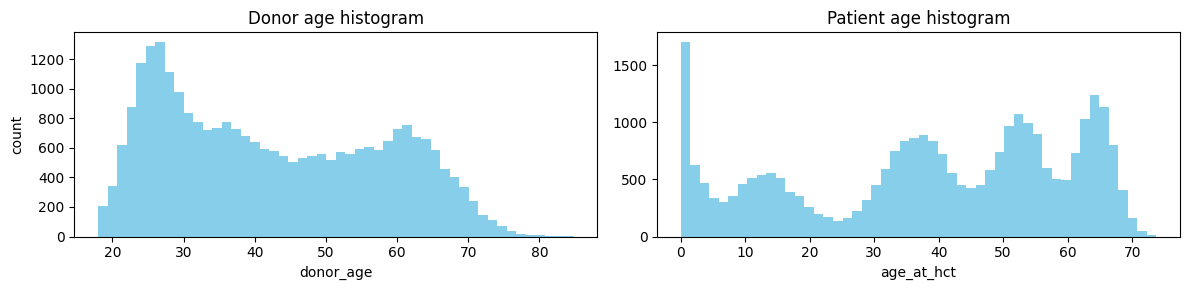

In [10]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.hist(train.donor_age, bins=50, color='skyblue')
plt.title('Donor age histogram')
plt.xlabel('donor_age')
plt.ylabel('count')
plt.subplot(1, 2, 2)
plt.title('Patient age histogram')
plt.hist(train.age_at_hct, bins=50, color='skyblue')
plt.xlabel('age_at_hct')
plt.tight_layout()
plt.show()

Our first thought was that different race groups had different modes, but the patient age distribution has the same five modes in every race group:

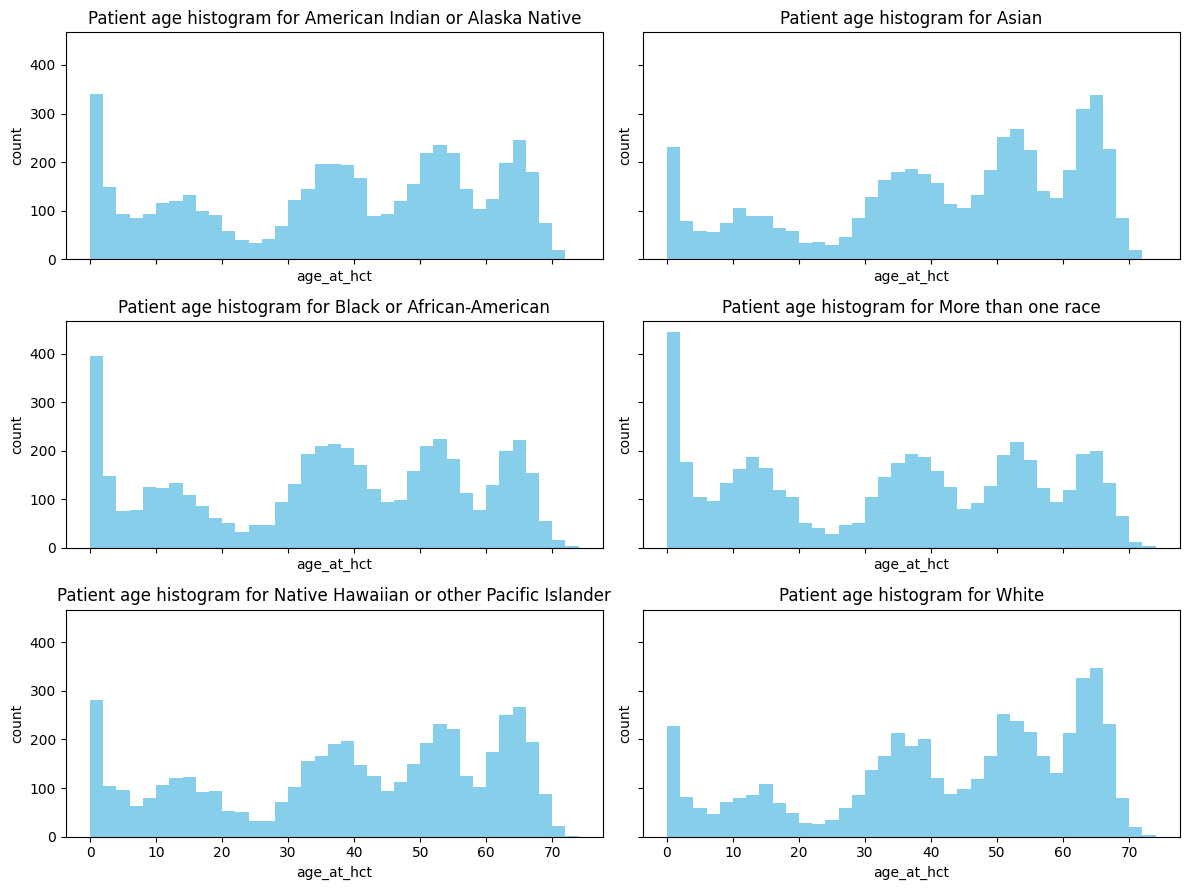

In [11]:
_, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 9))
for race_group, ax in zip(race_groups, axs.ravel()):
    ax.hist(train.age_at_hct[train.race_group == race_group],
            bins=np.linspace(0, 74, 38),
            color='skyblue')
    ax.set_title(f'Patient age histogram for {race_group}')
    ax.set_xlabel('age_at_hct')
    ax.set_ylabel('count')
plt.tight_layout()
plt.show()

Even stranger, The age of 0.044 years (i.e., 16 days) occurs 1005 times in the training dataset, whereas every other age occurs at most six times.  
Is hematopoietic cell transplantation a treatment which is often done to newborns? Possible. But we can't believe that these babies are all treated exactly when they are 16 days old. 

Text(0.044, 949.725, 'Age 0.044: 1005 occurrences')

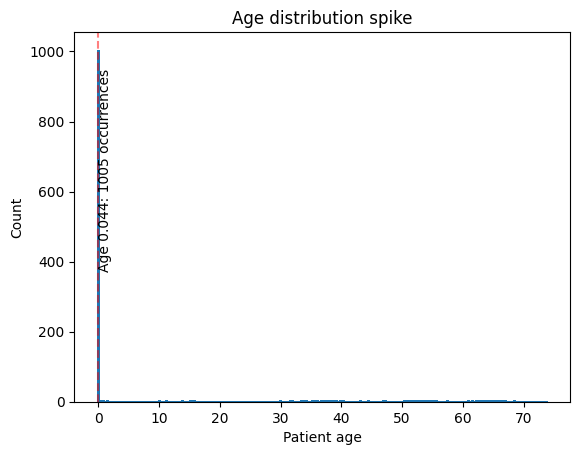

In [12]:
age_counts = pd.Series(train.age_at_hct.round(3).value_counts().sort_index())
plt.bar(age_counts.index, age_counts.values, width=0.5)
plt.title('Age distribution spike')
plt.xlabel('Patient age')
plt.ylabel('Count')

# Highlight the suspicious spike at age 0.044
plt.axvline(x=0.044, color='red', linestyle='--', alpha=0.5)
plt.text(0.044, plt.ylim()[1]*0.9,
         f'Age 0.044: {train.age_at_hct.value_counts().get(0.044, 0)} occurrences',
         rotation=90, verticalalignment='top')

##### Event time precision
The event time measurements are way too precise for medical time measurements, more than 3-decimal precision, and up to 19-decimal precision!  
Even if we look at the values of `efs_time`, which is measured in months, the recorded numbers don't really align to days for any month.  
Real clinical data typically uses whole days or months.  

It is unbeliveable that anyone would measure with up to 19-decimal precision for event time.  
And we doubt that possible events of a patient are recorded with a more exact unit than a day.  

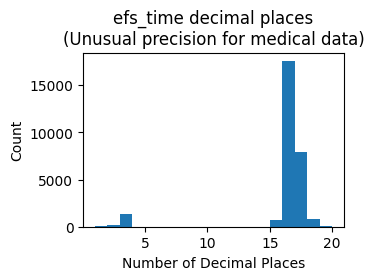

In [13]:
plt.subplot(2, 2, 4)
decimal_places = (train.efs_time % 1).apply(lambda x: len(str(x).split('.')[-1]))
plt.hist(decimal_places, bins=range(min(decimal_places), max(decimal_places) + 2, 1))
plt.title('efs_time decimal places\n(Unusual precision for medical data)')
plt.xlabel('Number of Decimal Places')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

##### HLA matching scores
There is high correlation between different HLA measures.  
Such high correlation is more than we expected.  
This suggests that there are redundant synthetic features in the data.

Text(0.5, 1.0, 'HLA matching scores correlation\n(Potential duplicated information)')

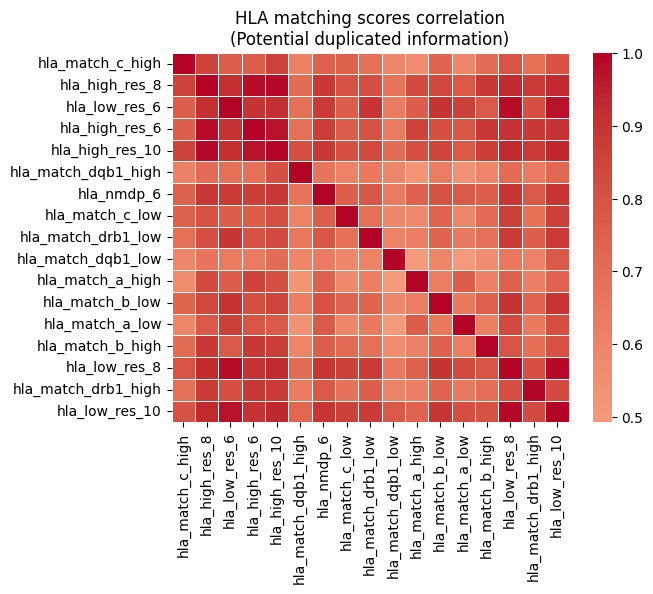

In [14]:
hla_cols = [col for col in train.columns if 'hla' in col]
hla_corr = train[hla_cols].corr()
sns.heatmap(hla_corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('HLA matching scores correlation\n(Potential duplicated information)')

##### Reviewing the data generation artifacts
Let's Review the data generation artifacts we found and their implications:

1. Race group distribution:
    - Perfectly balanced race groups (unrealistic in real-world data).
    - Each group has approximately 4800 samples.

2. Patient age distribution:
    - Unnatural 5-mode distribution.
    - Suspicious spike at exactly 0.044 years (16 days).

3. Event time precision:
    - Unusual higher than 3-decimal (and up to 19-decimal) precision for medical time measurements.
    - Real clinical data typically uses whole days or months.

4. HLA matching scores:
    - High correlation between different HLA measures suggests redundant synthetic features.

The balanced representation of race groups in this dataset suggests that it has been engineered to ensure equal representation rather than reflecting real-world distributions.  
While this helps create fairer models, it also means that results might not generalize well to actual clinical populations.  
Any findings should be interpreted with caution, especially when assessing disparities across racial groups.

The age distribution also does not fully reflect real-world patient demographics.  
This is crucial to consider when interpreting model results, as certain patterns may be artifacts of data preprocessing rather than genuine clinical insights.

The unusual precision of the event times, is another indicator of the dataset's synthetic nature.  
In real-world clinical settings, event times are typically measured in days or months, not fractions thereof.  
This artificial precision could lead to models learning patterns that don't reflect genuine clinical relationships.

The high correlation among different HLA matching scores suggests the presence of redundant information introduced during data generation.  
These features, intended to capture compatibility factors between donors and recipients,  
might exhibit artificially strong relationships in the synthetic dataset, potentially influencing model behavior and hindering the identification of truly impactful factors.

### Feature correlation
As we saw in the previous section, there is a high correlation between all of the HLA features.  
It is interesting to see if we can find some correlation between other features.  
Correlations can help us identify redundant features, where one variable provides almost the same information as another.  

Let's explore the relationships between numerical features.

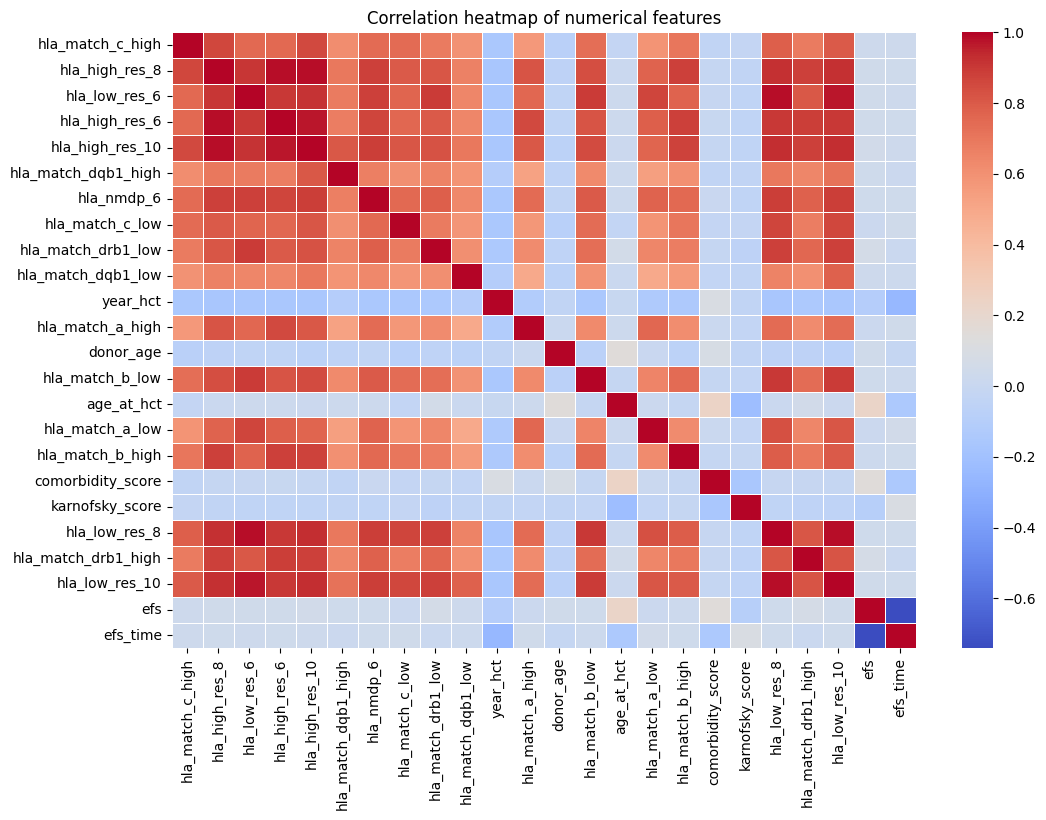

In [15]:
plt.figure(figsize=(12, 8))
corr_matrix = train.corr(numeric_only=True) # Only numerical columns
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation heatmap of numerical features")
plt.show()

We can see there isn't a high correlation between HLA features and other features,  
so lets remove them from the correlation matrix for an easier comparison of the other features.

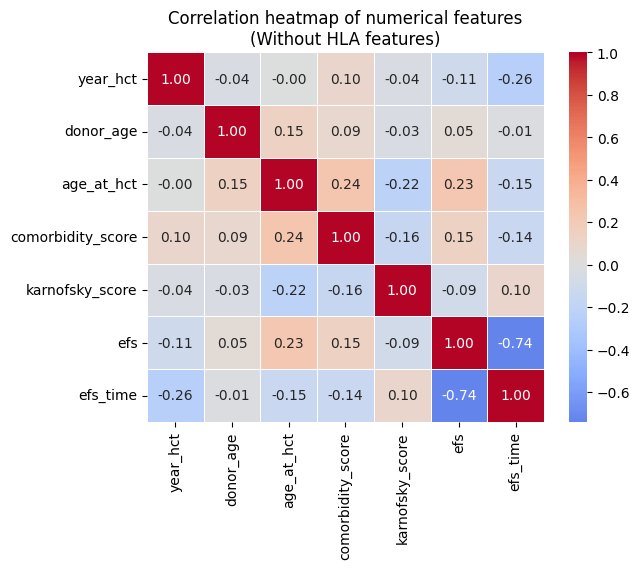

In [16]:
hla_cols = [col for col in train.columns if 'hla' not in col]
corr_matrix = train[hla_cols].corr(numeric_only=True) # Only numerical columns
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5, center=0, annot=True, fmt=".2f")
plt.title("Correlation heatmap of numerical features\n(Without HLA features)")
plt.show()

**HLA feature correlation**  
As we saw previously, all HLA features have high correlation with each other.  
Some correlation is expected, as they are all measuring similar compatibility factors between donors and patients.  
But we suspect that the higher than expected correlation comes as an artifact of the synthetic data.  

**Risk score correlation**  
Risk score seems hard to predict.  
`efs` and `efs_time` don’t have strong correlations with most features.  
This tells us that survival time depends on many small factors rather than one big predictor.  
Obviously they have high correlation with each other, as they both represent the prediction target (event-free survival).  

The major correlations we can find are:  
1. `efs_time` and `year_hct`  
2. `efs` and `age_at_hct`  

The first might be explained by having more time to follow up on patients (as HCT happened longer ago).  
If the year HCT happend at was recent, it is more likely that more patients had no event,  
and their `efs_time` measurements would be similar (as the time to event would still be counting and would start from similar points in time).  

The second might be explained by older patients having a higher chance for an event.  
Alternatively, it could be caused by the spike of newborns (16 days old) in the dataset.

**Age related correlation to Health scores**  
Aside from the correlation to `efs`, there is also some correlation between the patient's age to the Comorbidity and Karnofsky scores.  
This correlation might have the same source as the one to `efs`.  
It would make sense that an older patient would have more health issues (higher Comorbidity score) and worse physical condition (lower Karnofsky score).  
And that a younger patient would usually be healthier (in respect to older HCT patients).  

### Survival time by race

The survival function shows how many patients have no event for an amount of time ([Kaplan–Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator)).  
At month 0, 100% of the patients have no event. At month 20, only 40% - 60% remain without event, depending on their race group.  

The cumulative hazard is another representation of the same facts, it corresponds to the negative logarithm of the survival function ([Nelson–Aalen estimator](https://en.wikipedia.org/wiki/Nelson%E2%80%93Aalen_estimator)).

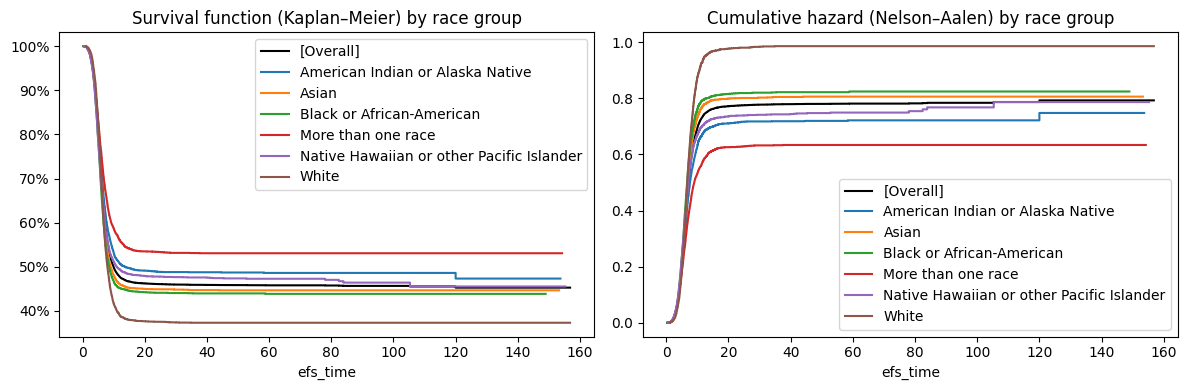

In [17]:
def survival_function(df):
    survival_df = df[['efs', 'efs_time']].groupby('efs_time').agg(['size', 'sum']).droplevel(0, axis=1).astype(int)
    survival_df['n_at_risk'] = survival_df['size'].sum() - survival_df['size'].shift().fillna(0).cumsum().astype(int)
    hazard = survival_df['sum'] / survival_df['n_at_risk'] 
    survival_df['cumulative_hazard'] = np.cumsum(hazard) # nelson_aalen_estimator
    survival_df['survival_probability'] = (1 - hazard).cumprod() # kaplan_meier_estimator
    return survival_df

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
survival_df = survival_function(train)
plt.step(survival_df.index, survival_df['survival_probability'], c='k', where="post", label='[Overall]')
plt.xlabel('efs_time')
for race_group in race_groups:
    subset = train.query('race_group == @race_group')
    survival_df = survival_function(subset)
    plt.step(survival_df.index, survival_df['survival_probability'], where="post", label=race_group)
plt.xlabel('efs_time')
plt.legend(loc='upper right')
plt.title('Survival function (Kaplan–Meier) by race group')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0)) # percent of xmax

plt.subplot(1, 2, 2)
survival_df = survival_function(train)
plt.step(survival_df.index, survival_df['cumulative_hazard'], c='k', where="post", label='[Overall]')
plt.xlabel('efs_time')
for race_group in race_groups:
    subset = train.query('race_group == @race_group')
    survival_df = survival_function(subset)
    plt.step(survival_df.index, survival_df['cumulative_hazard'], where="post", label=race_group)
plt.xlabel('efs_time')
plt.legend(loc='lower right')
plt.title('Cumulative hazard (Nelson–Aalen) by race group')

plt.tight_layout()
plt.show()

While most race groups have similar survival times,  
it is intresting to see that patients with "more than one race" have the highest probability of event-free survival, with some gap.  
On the other side, white patients have the lowest probability of event-free survival, with an even more significant gap.  

While the gap between the groups at the extremes seems significant, it is better to confirm this with traditional methods.  
We'll use the **Log-Rank Test**, a statistical test designed to compare survival distributions between groups.  
If the p-value is **less than 0.05**, it means the difference is **statistically significant** - one group truly has a better survival outcome than the other.  
If not, any differences we see could be due to chance.

In [18]:
from lifelines.statistics import logrank_test

# Select two race groups for comparison
race_group_1 = train[train["race_group"] == "White"]
race_group_2 = train[train["race_group"] == "More than one race"]

# Perform Log-Rank Test
log_rank_result = logrank_test(
    race_group_1["efs_time"], race_group_2["efs_time"],
    event_observed_A=race_group_1["efs"],
    event_observed_B=race_group_2["efs"]
)

# Print p-value to check statistical significance
print(f"Log-Rank Test p-value: {log_rank_result.p_value} {'< 0.05 ✅' if log_rank_result.p_value < 0.05 else '>= ❌'}")

Log-Rank Test p-value: 1.797992962773969e-49 < 0.05 ✅


The p-value obtained from the test is extremely small (<< 0.05).  
This means that the difference in survival rates between the "White" group and the "More than one race" group is statistically significant.  
In other words, the "More than one race" group experiences better survival outcomes than the "White" group, and this difference is unlikely due to random chance.

This might be explained by mixed people having better genes that make them healthier and more likely to have an event free survival.  
It might also mean that white people are genetically more inclined to suffer from an event after HCT.

### The significance of the race group
As we saw, the survival time differs significantly between the race groups in the dataset.  
Our goal is to develop accurate and fair survival models across diverse race groups.  
Do other features have significant differences across race groups?  
Let's find out with Chi-square tests for categorical features and Kruskal-Wallis for numerical:  

In [19]:
categorical_cols = train.select_dtypes(exclude=['number']).columns.drop('race_group')
numerical_cols = train.select_dtypes(include=['number']).columns

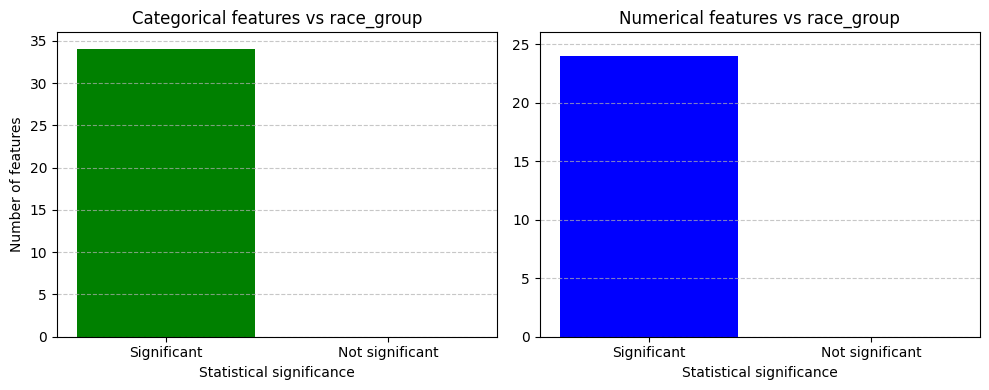

In [20]:
from scipy.stats import chi2_contingency, kruskal

# Get column types
categorical_cols = train.select_dtypes(exclude=['number']).columns.drop('race_group')
numerical_cols = train.select_dtypes(include=['number']).columns

# Significance results tracking
cat_significance = {'Significant': 0, 'Not significant': 0}
num_significance = {'Significant': 0, 'Not significant': 0}

# Chi-square for categorical features
for var in categorical_cols:
    contingency = pd.crosstab(train['race_group'], train[var])
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    if p_val < 0.05:
        cat_significance['Significant'] += 1
    else:
        cat_significance['Not significant'] += 1

# Kruskal-Wallis for numerical features
for var in numerical_cols:
    groups = [group[var].dropna() for name, group in train.groupby('race_group', observed=True)]
    stat, p_val = kruskal(*groups)
    if p_val < 0.05:
        num_significance['Significant'] += 1
    else:
        num_significance['Not significant'] += 1

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].bar(cat_significance.keys(), cat_significance.values(), color=['green', 'gray'])
axs[0].set_title('Categorical features vs race_group')
axs[0].set_ylabel('Number of features')
axs[0].set_ylim(0, max(cat_significance.values()) + 2)

axs[1].bar(num_significance.keys(), num_significance.values(), color=['blue', 'gray'])
axs[1].set_title('Numerical features vs race_group')
axs[1].set_ylim(0, max(num_significance.values()) + 2)

for ax in axs:
    ax.set_xlabel('Statistical significance')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

It seems all features in the dataset have a statistically significant difference across different race groups!  
This means that:
- For categorical features: the distributions of categories differ by race group.
- For numerical features: the distributions or medians differ across race groups.

Because of this correlation, our model’s performance must be assessed across race groups, which is a given in this challenge.

This discovery—that every feature differs by race—is not a flaw; it's a signal that systemic differences exist in the synthetic dataset (and by extension, in real-world data).  
This opens the door to:  
- Highlighting unfairness in predictive systems.
- Building models that don’t just predict well, but do so equitably.

### The significance of the prediction target
Checking for statistical significance between features and the prediction target helps identify which variables are informative for modeling.  
Significant features are more likely to contribute meaningfully to prediction accuracy.  
Conversely, non-significant features may introduce noise or redundancy, especially in models that don't perform internal feature selection.  
It also helps highlight potential confounders or weak predictors, guiding decisions around feature inclusion, transformation, or removal.

In [21]:
from scipy.stats import chi2_contingency, kruskal, spearmanr
import pandas as pd

# Separate columns
categorical_cols = train.select_dtypes(exclude=['number']).columns.drop(['race_group'], errors='ignore')
numerical_cols = train.select_dtypes(include=['number']).columns.drop(['efs', 'efs_time'], errors='ignore')
non_sig_efs = []
non_sig_efs_time = []

# 1. Test features vs efs
for var in categorical_cols:
    contingency = pd.crosstab(train['efs'], train[var])
    _, p_val, _, _ = chi2_contingency(contingency)
    if p_val >= 0.05:
        non_sig_efs.append(var)

for var in numerical_cols:
    groups = [group[var].dropna() for _, group in train.groupby('efs', observed=True)]
    _, p_val = kruskal(*groups)
    if p_val >= 0.05:
        non_sig_efs.append(var)

# 2. Test features vs efs_time
for var in categorical_cols:
    groups = [group['efs_time'].dropna() for _, group in train.groupby(var, observed=True)]
    if len(groups) > 1:
        _, p_val = kruskal(*groups)
        if p_val >= 0.05:
            non_sig_efs_time.append(var)

for var in numerical_cols:
    _, p_val = spearmanr(train[var], train['efs_time'], nan_policy='omit')
    if p_val >= 0.05:
        non_sig_efs_time.append(var)

# Display results
print("🔍 Non-significant features vs efs:", non_sig_efs)
print("🔍 Non-significant features vs efs_time:", non_sig_efs_time)


🔍 Non-significant features vs efs: ['rituximab', 'rheum_issue']
🔍 Non-significant features vs efs_time: ['vent_hist', 'mrd_hct', 'hla_match_dqb1_high', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'hla_match_drb1_high']


Out of all features tested:
- 54 were significantly related to `efs`, with only 2 non-significant: `rituximab` and `rheum_issue`.
- 50 were significantly related to `efs_time`, with 6 non-significant: `vent_hist`, `mrd_hct`, and four HLA-related fields (`hla_match_drb1_low/high`, `hla_match_dqb1_low/high`).

These results suggest most features in the dataset carry predictive signal.  
Let's review the few non-significant features:

**Non-significant features vs `efs`**
1. `rituximab`:
    - Likely indicates whether the patient received Rituximab, a monoclonal antibody used in cancer treatment.
    - Might suggest this treatment didn’t make a statistically significant difference in event-free survival in this cohort — or the effect is too small or confounded.

2. `rheum_issue`:
    - Likely flags patients with rheumatological issues (e.g., autoimmune conditions).
    - These conditions might not influence survival post-HCT in this dataset.

**Non-significant features vs `efs_time`**
1. `vent_hist`:
    - Possibly indicates prior use of mechanical ventilation.
    - While serious, it may not be predictive of how long a patient stays event-free post-HCT.

2. `mrd_hct`:
    - May relate to Minimal Residual Disease (MRD) status at transplant.
    - Surprisingly non-significant — maybe due to imbalanced distribution or noise.

3. HLA matching features:  
    - `hla_match_drb1_low`, `hla_match_drb1_high`, `hla_match_dqb1_low`, `hla_match_dqb1_high`
    - These are fine-grained human leukocyte antigen (HLA) match indicators, relevant for donor compatibility.

Despite clinical relevance, these specific sub-loci might not significantly influence event-free survival time in this synthetic dataset.  
OR: They might be redundant with other matching variables already in the model (like global HLA match).  

As we are not sure if the non-significant features are actually not relevant, we have decided to keep them in our data.

# Evaluation
This competition is about equity in the predictions. This means that we score the predictions per race group and then derive the final score from these six sub-scores.  
As the official implementation of the competition metric doesn't output the scores per race group, we've written our own implementation, which gives more transparency.

We also show the scores recieved for each fold in the cross validation.
The overall score is the mean of all of the fold's scores.

In [22]:
kf = StratifiedKFold(n_splits=5 ,shuffle=True, random_state=1)
all_model_data = {'scores': {}, 'models': {}, 'times': {}}

In [ ]:
def evaluate_fold(y_va_pred, X_va, idx_va, fold):
    """Compute and print the metrics (concordance index) per race group for a single fold.

    Returns:
        List of c-index values, one per race group.
    """
    metric_list = []
    for race in race_groups:
        mask = X_va.race_group.values == race
        c_index_race = concordance_index(
            train.efs_time.iloc[idx_va][mask],
            - y_va_pred[mask],
            train.efs.iloc[idx_va][mask]
        )
        metric_list.append(c_index_race)
    return metric_list


def display_overall(all_scores, label):
    """Compute and print the overall metrics (concordance index)."""
    df = pd.DataFrame(all_scores, columns=race_groups)
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df.columns = [f"Fold {i}" for i in range(1, df.shape[1] + 1)]
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values

    print(f"# Overall score for {label}: {df.loc['score', 'Overall']:.3f}")
    all_model_data['scores'][label] = df.loc['score', 'Overall']

    display(
        df.iloc[:len(race_groups)]
        .style
        .format(precision=3)
        .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
        .concat(df.iloc[len(race_groups):].style.format(precision=3))
    )

To make model evaluation easier, we also created a function that would run cross-validation for a model, evaluate per fold and display overall performance.  
This is something we will do for each model.  

In [24]:
import time
import datetime
import humanize

def humanize_time(time_in_seconds):
    return humanize.precisedelta(datetime.timedelta(seconds=time_in_seconds))

def evaluate_model_cv(model_name, model_fn):
    """Run cross-validation for a model, evaluating per fold, saving the models, and measuring time.

    Args:
        model_name: A string label for this model
        model_fn: A function that takes (idx_tr, idx_va) and returns (model, y_va_pred, X_va)
    """
    start_time = time.time()  # Start time for model training/evaluation
    all_scores = []

    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.race_group)):
        model, y_va_pred, X_va = model_fn(idx_tr, idx_va)
        fold_scores = evaluate_fold(y_va_pred, X_va, idx_va, fold)
        all_scores.append(fold_scores)

        # Save the model for this fold
        if model_name not in all_model_data['models']:
            all_model_data['models'][model_name] = {}
        all_model_data['models'][model_name][fold] = model
    
    end_time = time.time()  # End time after completing cross-validation
    total_time = end_time - start_time  # Calculate total time for this model
    
    # Save model evaluation time
    all_model_data['times'][model_name] = total_time
    print(f"# Total time for {model_name}: {humanize_time(total_time)}")

    display_overall(all_scores, model_name)


# Cox proportional hazards model
One method for survival analysis, is the [Cox proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model).  
Which is implemented in XGBoost and in CatBoost.

Let's try the first method.

### XGBoost Cox proportional hazards model
Cox proportional hazards model with XGBoost.  
This model expects that the two target columns be combined into one (`y = np.where(train.efs == 1, train.efs_time, -train.efs_time)`, negative target values are considered right censored)

In [ ]:
def cox_xgboost(idx_tr, idx_va):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y = np.where(train.efs == 1, train.efs_time, -train.efs_time)
    y_tr = y[idx_tr]
    
    xgb_cox_params = {'objective': 'survival:cox', 'grow_policy': 'depthwise', 
                      'n_estimators': 700, 'learning_rate': 0.0254, 'max_depth': 8, 
                      'reg_lambda': 0.116, 'reg_alpha': 0.139, 'min_child_weight': 23.8,
                      'colsample_bytree': 0.59, 'subsample': 0.7, 'tree_method': 'hist',
                      'enable_categorical': True}
    model = xgboost.XGBRegressor(**xgb_cox_params)
    model.fit(X_tr, y_tr) # negative values are considered right censored
    y_va_pred = model.predict(X_va) # predicts hazard factor
    return model, y_va_pred, X_va

evaluate_model_cv('Cox Proportional Hazards XGBoost', cox_xgboost)

# Total time for Cox Proportional Hazards XGBoost: 10.09 seconds
# Overall score for Cox Proportional Hazards XGBoost: 0.670


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.689,0.693,0.702,0.677,0.689,0.690
Asian,0.706,0.691,0.690,0.693,0.709,0.698
Black or African-American,0.684,0.661,0.665,0.697,0.671,0.676
More than one race,0.690,0.687,0.680,0.678,0.691,0.685
Native Hawaiian or other Pacific Islander,0.671,0.682,0.666,0.673,0.686,0.676
White,0.653,0.664,0.675,0.684,0.677,0.671
mean,0.682,0.680,0.680,0.684,0.687,0.682
std,0.016,0.013,0.013,0.009,0.012,0.013
score,0.666,0.667,0.667,0.675,0.675,0.670


### Catboost Cox proportional hazards model
Cox proportional hazards model with CatBoost.  
This model expects the targets in the same format as the XGBoost Cox model.

In [26]:
def cox_catboost(idx_tr, idx_va):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y = np.where(train.efs == 1, train.efs_time, -train.efs_time)
    y_tr = y[idx_tr]

    cb_cox_params = {'loss_function': 'Cox', 'grow_policy': 'SymmetricTree',
                     'n_estimators': 800, 'learning_rate': 0.092, 'l2_leaf_reg': 2.5,
                     'max_depth': 7, 'colsample_bylevel': 0.84, 'subsample': 0.9, 
                     'random_strength': 0.8, 'verbose': False}
    
    model = catboost.CatBoostRegressor(**cb_cox_params, cat_features=cat_features)
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va) # predicts log of hazard factor
    return model, y_va_pred, X_va

evaluate_model_cv('Cox Proportional Hazards CatBoost', cox_catboost)

# Total time for Cox Proportional Hazards CatBoost: 3 minutes and 55.35 seconds
# Overall score for Cox Proportional Hazards CatBoost: 0.670


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.689,0.703,0.699,0.676,0.691,0.692
Asian,0.706,0.694,0.685,0.695,0.706,0.697
Black or African-American,0.675,0.664,0.672,0.691,0.670,0.674
More than one race,0.691,0.689,0.680,0.676,0.684,0.684
Native Hawaiian or other Pacific Islander,0.669,0.683,0.670,0.676,0.692,0.678
White,0.656,0.662,0.674,0.673,0.674,0.668
mean,0.681,0.682,0.680,0.681,0.686,0.682
std,0.016,0.015,0.010,0.009,0.012,0.012
score,0.665,0.668,0.670,0.673,0.674,0.670


# Accelerated failure time model
Another method for survival analysis, is the [Accelerated failure time model](https://en.wikipedia.org/wiki/Accelerated_failure_time_model).  
Which is also implemented in XGBoost and in CatBoost.

We shall try it too.

### XGBoost Accelerated failure time model
Accelerated failure time model with XGBoost.  
This model expects the lower and upper bounds for the target in a special form in a DMatrix.

In [27]:
def aft_xgboost(idx_tr, idx_va):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    d_tr = xgboost.DMatrix(X_tr, enable_categorical=True)
    d_tr.set_float_info('label_lower_bound', train.efs_time.iloc[idx_tr])
    d_tr.set_float_info('label_upper_bound', np.where(train.efs.iloc[idx_tr] == 0, np.inf, train.efs_time.iloc[idx_tr]))
    d_va = xgboost.DMatrix(X_va, enable_categorical=True)
    d_va.set_float_info('label_lower_bound', train.efs_time.iloc[idx_va])
    d_va.set_float_info('label_upper_bound', np.where(train.efs.iloc[idx_va] == 0, np.inf, train.efs_time.iloc[idx_va]))
    xgboost_aft_params = {'learning_rate': 0.08, 'max_depth': 4, 'reg_lambda': 3, 'aft_loss_distribution_scale': 0.9,
                          'reg_alpha': 0.24, 'gamma': 0.033, 'min_child_weight': 82.58861553592878,
                          'colsample_bytree': 0.5662198438953138, 'max_bin': 53, 'subsample': 0.7456329821182728, 
                          'objective': 'survival:aft', 'grow_policy': 'depthwise', 'tree_method': 'hist',
                          'aft_loss_distribution': 'normal'}
    model = xgboost.train(xgboost_aft_params,
                        d_tr,
                        num_boost_round=300,
                       )
    y_va_pred = - model.predict(d_va) # model predicts time of event
    return model, y_va_pred, X_va

evaluate_model_cv('Accelerated Failure Time XGBoost', aft_xgboost)

# Total time for Accelerated Failure Time XGBoost: 2.31 seconds
# Overall score for Accelerated Failure Time XGBoost: 0.664


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.683,0.690,0.688,0.674,0.685,0.684
Asian,0.698,0.691,0.680,0.684,0.700,0.691
Black or African-American,0.677,0.648,0.660,0.684,0.664,0.667
More than one race,0.689,0.681,0.680,0.673,0.682,0.681
Native Hawaiian or other Pacific Islander,0.659,0.674,0.664,0.668,0.686,0.670
White,0.648,0.661,0.670,0.668,0.673,0.664
mean,0.676,0.674,0.674,0.675,0.682,0.676
std,0.017,0.015,0.010,0.007,0.011,0.012
score,0.659,0.659,0.664,0.668,0.671,0.664


### CatBoost Accelerated failure time model
Accelerated failure time model with CatBoost.  
This model expects the lower and upper bounds for the target in the form of a two-column array.

In [28]:
def aft_catboost(idx_tr, idx_va):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y = np.column_stack([train.efs_time, np.where(train.efs == 1, train.efs_time, -1)])
    y_tr = y[idx_tr]
    cb_aft_params = {'loss_function': 'SurvivalAft', 'grow_policy': 'SymmetricTree',
                     'n_estimators': 800, 'learning_rate': 0.066, 'l2_leaf_reg': 4.4,
                     'max_depth': 5, 'colsample_bylevel': 0.776, 'random_strength': 0.9, 
                     'verbose': False}
    model = catboost.CatBoostRegressor(**cb_aft_params, cat_features=cat_features)
    model.fit(X_tr, y_tr)
    y_va_pred = - model.predict(X_va) # model predicts log of time of event
    return model, y_va_pred, X_va

evaluate_model_cv('Accelerated Failure Time CatBoost', aft_catboost)

# Total time for Accelerated Failure Time CatBoost: 2 minutes and 47.03 seconds
# Overall score for Accelerated Failure Time CatBoost: 0.664


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.686,0.698,0.688,0.676,0.683,0.686
Asian,0.699,0.692,0.682,0.685,0.698,0.691
Black or African-American,0.676,0.651,0.663,0.676,0.665,0.666
More than one race,0.693,0.679,0.681,0.673,0.680,0.681
Native Hawaiian or other Pacific Islander,0.665,0.680,0.662,0.667,0.690,0.673
White,0.652,0.655,0.669,0.661,0.672,0.662
mean,0.678,0.676,0.674,0.673,0.682,0.677
std,0.016,0.017,0.010,0.007,0.011,0.012
score,0.662,0.658,0.664,0.665,0.671,0.664


# Target transformation models and regression with mean squared error

The competition task can be interpreted as predicting the order of events for the patients.  
Who has an event first? Who second? ... Who has an event last? and who survives without an event at all?  
With a suitable target transformation, we can apply the usual regression algorithms which optimize MSE or similar metrics.

### Target transformations
As we saw in the EDA, patients with a known event, mostly have an `efs_time` between 0 and 15, whereas most unkowns have an `efs_time` between 15 and 160.  
This distribution is problematic for regression models.  
We want predictions to have high discriminative power for the patients who have a known event, but we don't need to distinguish between unkowns.  
We can achieve this result by stretching the range of the patients with a known event and compressing the range of the unkowns.

Let's create such a transformation to use for our model:  

In [29]:
def transform_survival_probability(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times"""
    kmf = KaplanMeierFitter()
    kmf.fit(time, event)
    return kmf.survival_function_at_times(time).values

The next diagram shows how a typical target transformation stretches and compresses the ranges.  
We use the transformation above as the example:

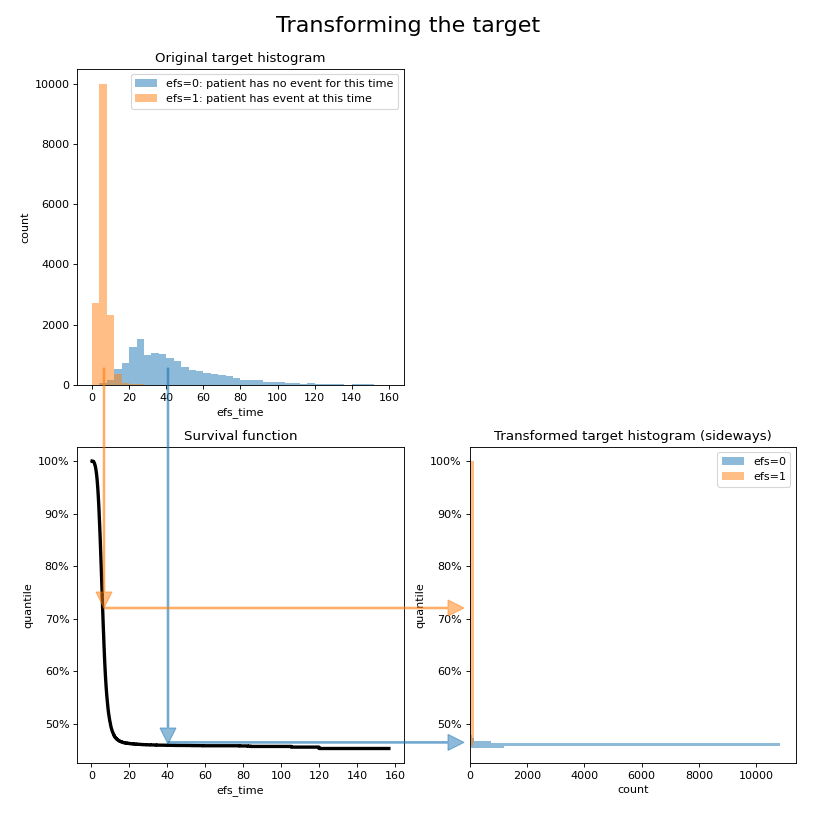

In [30]:
y_quantile = transform_survival_probability(time=train.efs_time, event=train.efs)
survival_df = survival_function(train)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=80)

axs[0, 0].hist(train.efs_time[train.efs == 0], bins=np.linspace(0, 160, 41), label='efs=0: patient has no event for this time', alpha=0.5)
axs[0, 0].hist(train.efs_time[train.efs == 1], bins=np.linspace(0, 160, 41), label='efs=1: patient has event at this time', alpha=0.5)
axs[0, 0].legend()
axs[0, 0].set_xlabel('efs_time')
axs[0, 0].set_ylabel('count')
axs[0, 0].set_title('Original target histogram')

axs[0, 1].set_axis_off()

axs[1, 0].step(survival_df.index, survival_df['survival_probability'], c='k', lw=3, where="post", label='[Overall]')
axs[1, 0].set_xlabel('efs_time')
axs[1, 0].set_ylabel("quantile")
axs[1, 0].set_title("Survival function")
axs[1, 0].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

axs[1, 1].hist(y_quantile[train.efs==0], bins=100, label="efs=0", orientation=u'horizontal', alpha=0.5)
axs[1, 1].hist(y_quantile[train.efs==1], bins=100, label="efs=1", orientation=u'horizontal', alpha=0.5)
axs[1, 1].legend()
axs[1, 1].set_ylabel("quantile")
axs[1, 1].set_xlabel("count")
axs[1, 1].set_title("Transformed target histogram (sideways)")
axs[1, 1].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.add_axes(ax)
ax.arrow(0.2, 0.55, 0, -0.47, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(0), alpha=0.5, head_width=0.02, head_length=0.02)
ax.arrow(0.2, 0.082, 0.37, 0, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(0), alpha=0.5, head_width=0.02, head_length=0.02)
ax.arrow(0.12, 0.55, 0, -0.3, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(1), alpha=0.5, head_width=0.02, head_length=0.02)
ax.arrow(0.12, 0.25, 0.45, 0, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(1), alpha=0.5, head_width=0.02, head_length=0.02)

plt.suptitle('Transforming the target', y=0.99, size=20)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.tight_layout()
plt.show()

We will add 4 more possible target transformations to test:

In [31]:
def transform_partial_hazard(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times"""
    data = pd.DataFrame({'efs_time': time, 'efs': event, 'time': time, 'event': event})
    cph = CoxPHFitter()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cph.fit(data, duration_col='time', event_col='event')
    return cph.predict_partial_hazard(data)

def transform_separate(time, event):
    """Transform the target by separating events from non-events"""
    transformed = time.values.copy()
    mx = transformed[event == 1].max() # last patient that has a known event
    mn = transformed[event == 0].min() # first patient that does not have a known event
    transformed[event == 0] = time[event == 0] + mx - mn
    transformed = rankdata(transformed)
    transformed[event == 0] += len(transformed) // 2
    transformed = transformed / transformed.max()
    return - transformed

def transform_rank_log(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times"""
    transformed = time.values.copy()
    mx = transformed[event == 1].max() # last patient that has a known event
    mn = transformed[event == 0].min() # first patient that does not have a known event
    transformed[event == 0] = time[event == 0] + mx - mn
    transformed = rankdata(transformed)
    transformed[event == 0] += len(transformed) * 2
    transformed = transformed / transformed.max()
    transformed = np.log(transformed)
    return - transformed

def transform_quantile(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times"""
    transformed = np.full(len(time), np.nan)
    transformed_with_event = quantile_transform(- time[event == 1].values.reshape(-1, 1)).ravel()
    transformed[event == 1] = transformed_with_event
    transformed[event == 0] = transformed_with_event.min() - 0.3
    return transformed


### XGBoost MSE loss with five different target transformations
We now plot the histograms of the five possible transformations we have created, and then fit regression models with MSE loss to each of the transformed targets.

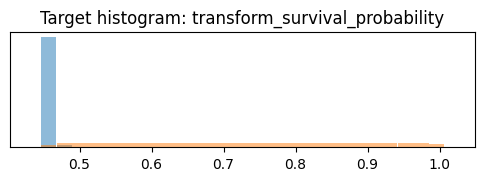

transform_survival_probability
# Total time for transform_survival_probability XGBoost (MSE): 8.13 seconds
# Overall score for transform_survival_probability XGBoost (MSE): 0.670


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.680,0.685,0.693,0.673,0.683,0.683
Asian,0.701,0.684,0.691,0.693,0.701,0.694
Black or African-American,0.685,0.660,0.663,0.695,0.671,0.675
More than one race,0.684,0.687,0.683,0.671,0.682,0.681
Native Hawaiian or other Pacific Islander,0.659,0.673,0.673,0.671,0.687,0.673
White,0.670,0.664,0.675,0.682,0.688,0.676
mean,0.680,0.675,0.680,0.681,0.685,0.680
std,0.013,0.011,0.011,0.010,0.009,0.011
score,0.667,0.665,0.669,0.671,0.676,0.670


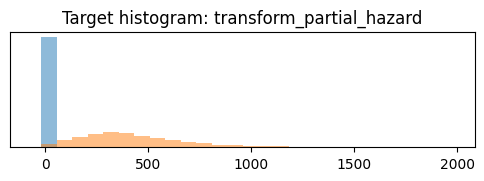

transform_partial_hazard
# Total time for transform_partial_hazard XGBoost (MSE): 17.28 seconds
# Overall score for transform_partial_hazard XGBoost (MSE): 0.669


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.677,0.683,0.694,0.676,0.681,0.682
Asian,0.699,0.683,0.688,0.698,0.700,0.693
Black or African-American,0.684,0.661,0.659,0.693,0.669,0.673
More than one race,0.683,0.683,0.680,0.671,0.682,0.680
Native Hawaiian or other Pacific Islander,0.662,0.669,0.675,0.670,0.682,0.671
White,0.668,0.662,0.674,0.683,0.685,0.674
mean,0.679,0.674,0.678,0.682,0.683,0.679
std,0.012,0.010,0.011,0.011,0.009,0.011
score,0.667,0.664,0.667,0.671,0.674,0.669


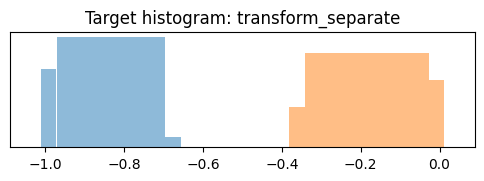

transform_separate
# Total time for transform_separate XGBoost (MSE): 7.69 seconds
# Overall score for transform_separate XGBoost (MSE): 0.666


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.686,0.699,0.689,0.677,0.687,0.688
Asian,0.704,0.693,0.687,0.687,0.702,0.694
Black or African-American,0.677,0.648,0.665,0.684,0.667,0.668
More than one race,0.691,0.687,0.683,0.674,0.681,0.683
Native Hawaiian or other Pacific Islander,0.663,0.685,0.667,0.667,0.686,0.674
White,0.646,0.658,0.671,0.670,0.676,0.664
mean,0.678,0.678,0.677,0.676,0.683,0.679
std,0.019,0.018,0.010,0.007,0.011,0.013
score,0.659,0.660,0.667,0.669,0.672,0.666


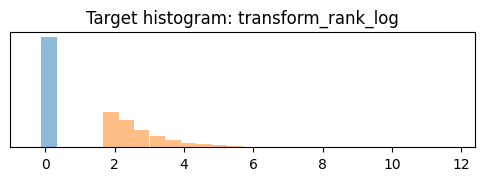

transform_rank_log
# Total time for transform_rank_log XGBoost (MSE): 7.58 seconds
# Overall score for transform_rank_log XGBoost (MSE): 0.672


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.684,0.695,0.699,0.681,0.688,0.689
Asian,0.705,0.689,0.691,0.704,0.708,0.699
Black or African-American,0.685,0.664,0.665,0.692,0.673,0.676
More than one race,0.691,0.693,0.689,0.679,0.686,0.688
Native Hawaiian or other Pacific Islander,0.669,0.680,0.678,0.675,0.686,0.678
White,0.659,0.659,0.676,0.683,0.682,0.672
mean,0.682,0.680,0.683,0.686,0.687,0.684
std,0.015,0.014,0.011,0.010,0.011,0.012
score,0.667,0.666,0.672,0.676,0.677,0.672


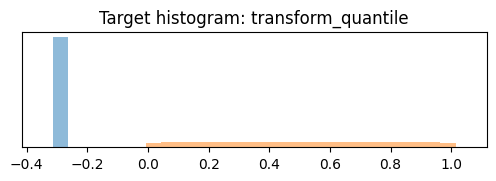

transform_quantile
# Total time for transform_quantile XGBoost (MSE): 7.60 seconds
# Overall score for transform_quantile XGBoost (MSE): 0.674


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.691,0.696,0.701,0.681,0.693,0.692
Asian,0.709,0.692,0.694,0.699,0.709,0.700
Black or African-American,0.687,0.664,0.668,0.696,0.674,0.678
More than one race,0.695,0.696,0.690,0.679,0.690,0.690
Native Hawaiian or other Pacific Islander,0.672,0.685,0.675,0.678,0.690,0.680
White,0.662,0.666,0.678,0.684,0.687,0.675
mean,0.686,0.683,0.684,0.686,0.690,0.686
std,0.015,0.013,0.012,0.008,0.010,0.012
score,0.671,0.670,0.673,0.678,0.680,0.674


In [32]:
def transform_model_fn(idx_tr, idx_va, transformation):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = transformation(time=train.iloc[idx_tr].efs_time, event=train.iloc[idx_tr].efs)

    model = xgboost.XGBRegressor(
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
    )
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va) # predicts quantile
    return model, y_va_pred, X_va

for transformation in [transform_survival_probability,
                       transform_partial_hazard,
                       transform_separate,
                       transform_rank_log,
                       transform_quantile,
                      ]:
    plt.figure(figsize=(6, 1.5))
    target = transformation(time=train.efs_time, event=train.efs)
    vmin, vmax = 1.09 * target.min() - 0.09 * target.max(), 1.09 * target.max() - 0.09 * target.min()
    plt.hist(target[train.efs == 0], bins=np.linspace(vmin, vmax, 31), density=True, label='efs=0: patient has no event for this time', alpha=0.5)
    plt.hist(target[train.efs == 1], bins=np.linspace(vmin, vmax, 31), density=True, label='efs=1: patient has event at this time', alpha=0.5)
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.title('Target histogram: ' + transformation.__name__)
    plt.show()
    
    print(transformation.__name__)
    
    wrapped_transform_model_fn = lambda idx_tr, idx_va: transform_model_fn(idx_tr, idx_va, transformation)
    evaluate_model_cv(f'{transformation.__name__} XGBoost (MSE)', wrapped_transform_model_fn)
    print()

# A linear model

The linear model [CoxPHFitter](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#cox-s-proportional-hazard-model) needs one-hot encoding and missing value imputation.  
This is a Cox proportional hazards model with a linear implementation. This model expects time and event columns in a dataframe.

In [33]:
def linear_cox(idx_tr, idx_va):
    preproc = ColumnTransformer([('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features),
                                ],
                                remainder=SimpleImputer(strategy='median'),
                                verbose_feature_names_out=False
                               ).set_output(transform='pandas')
    X_tr = preproc.fit_transform(train.iloc[idx_tr])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X_va = preproc.transform(train.iloc[idx_va])
    model = CoxPHFitter(penalizer=.01)
    feats = [f for f in X_tr.columns if f not in ['gvhd_proph_FK+- others(not MMF,MTX)']]
    model.fit(X_tr[feats], duration_col='efs_time', event_col='efs')
    X_va['race_group'] = train.race_group.iloc[idx_va]
    y_va_pred = model.predict_partial_hazard(X_va[feats])
    return model, y_va_pred, X_va

evaluate_model_cv('Cox Proportional Hazards Linear', linear_cox)

# Total time for Cox Proportional Hazards Linear: 52.49 seconds
# Overall score for Cox Proportional Hazards Linear: 0.656


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.675,0.682,0.678,0.667,0.678,0.676
Asian,0.699,0.672,0.672,0.687,0.693,0.685
Black or African-American,0.672,0.650,0.655,0.673,0.661,0.662
More than one race,0.684,0.683,0.677,0.667,0.669,0.676
Native Hawaiian or other Pacific Islander,0.657,0.676,0.660,0.663,0.675,0.666
White,0.634,0.632,0.659,0.658,0.664,0.650
mean,0.670,0.666,0.667,0.669,0.673,0.669
std,0.020,0.019,0.009,0.009,0.011,0.014
score,0.650,0.647,0.658,0.660,0.663,0.656


# Conclusions

### Final comparison

For the time being, the gradient-boosted proportional hazard models (Cox regression, blue) and the transformed-target models (pink) win.  
Among the target transformations, `transform_quantile` is best.  
The AFT models (green) perhaps need more hyperparameter tuning.

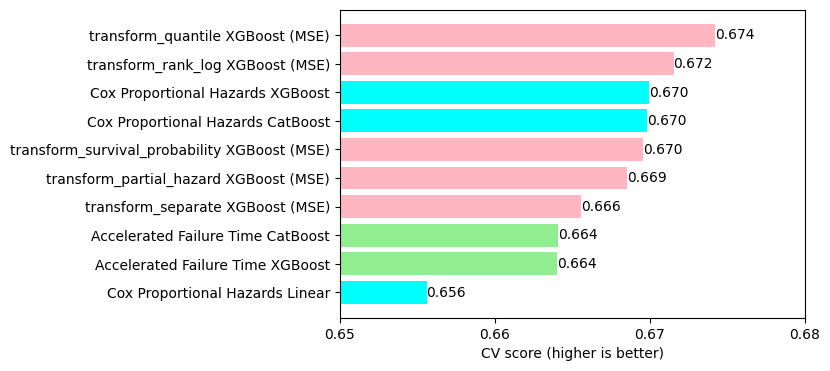

In [34]:
result_df = pd.DataFrame(all_model_data['scores'], index=['score']).T
result_df = result_df.sort_values('score', ascending=True)

plt.figure(figsize=(6, len(result_df) * 0.4))

color = np.where(result_df.index.str.contains('Proportional'),
                 'cyan',
                 np.where(result_df.index.str.contains('Accelerated'), 'lightgreen', 
                          'lightpink'))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color=color)
plt.gca().bar_label(bars, fmt='%.3f')
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlim(0.65, 0.68)
plt.xticks([0.65, 0.66, 0.67, 0.68])
plt.xlabel('CV score (higher is better)')
plt.show()

In terms of running time, XGBoost models win overall,  
where the Accelerated Failure Time is the fastest of them all (2.25 seconds!), and the transform_partial_hazard is the slowest of them all (18.43 seconds).  

The linear model is slower running at slightly above 1 minute.  
And the CatBoost models are the slowest, running at over 2 minutes and up to less then 4 minutes.  

Overall, the CV times are still pretty fast, most likely due to the dataset being on the smaller size.

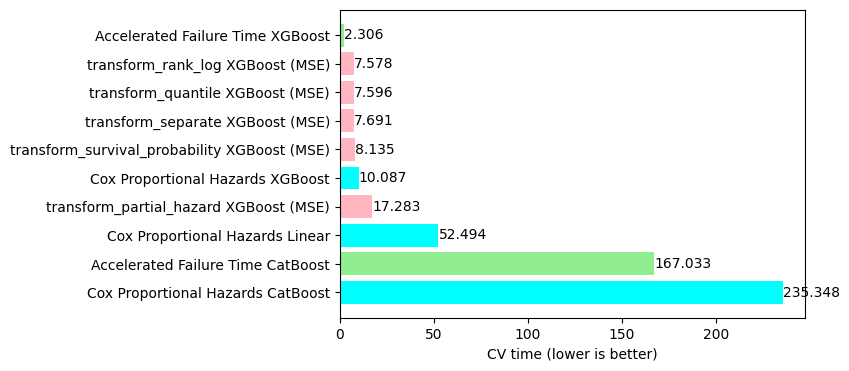

In [35]:
result_df = pd.DataFrame(all_model_data['times'], index=['time']).T
result_df = result_df.sort_values('time', ascending=False)
# with pd.option_context("display.precision", 3): display(result_df)
plt.figure(figsize=(6, len(result_df) * 0.4))

color = np.where(result_df.index.str.contains('Proportional'),
                 'cyan',
                 np.where(result_df.index.str.contains('Accelerated'), 'lightgreen', 
                          'lightpink'))
bars = plt.barh(np.arange(len(result_df)), result_df.time, color=color)
plt.gca().bar_label(bars, fmt='%.3f')
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlabel('CV time (lower is better)')
plt.show()

All things considered, the `transform_quantile` seems to be our best model overall,  
with the best score, and a short running time too.

### Feature importance
As `transform_quantile` was our best model,  
let's delve deeper into what features it cared about most:

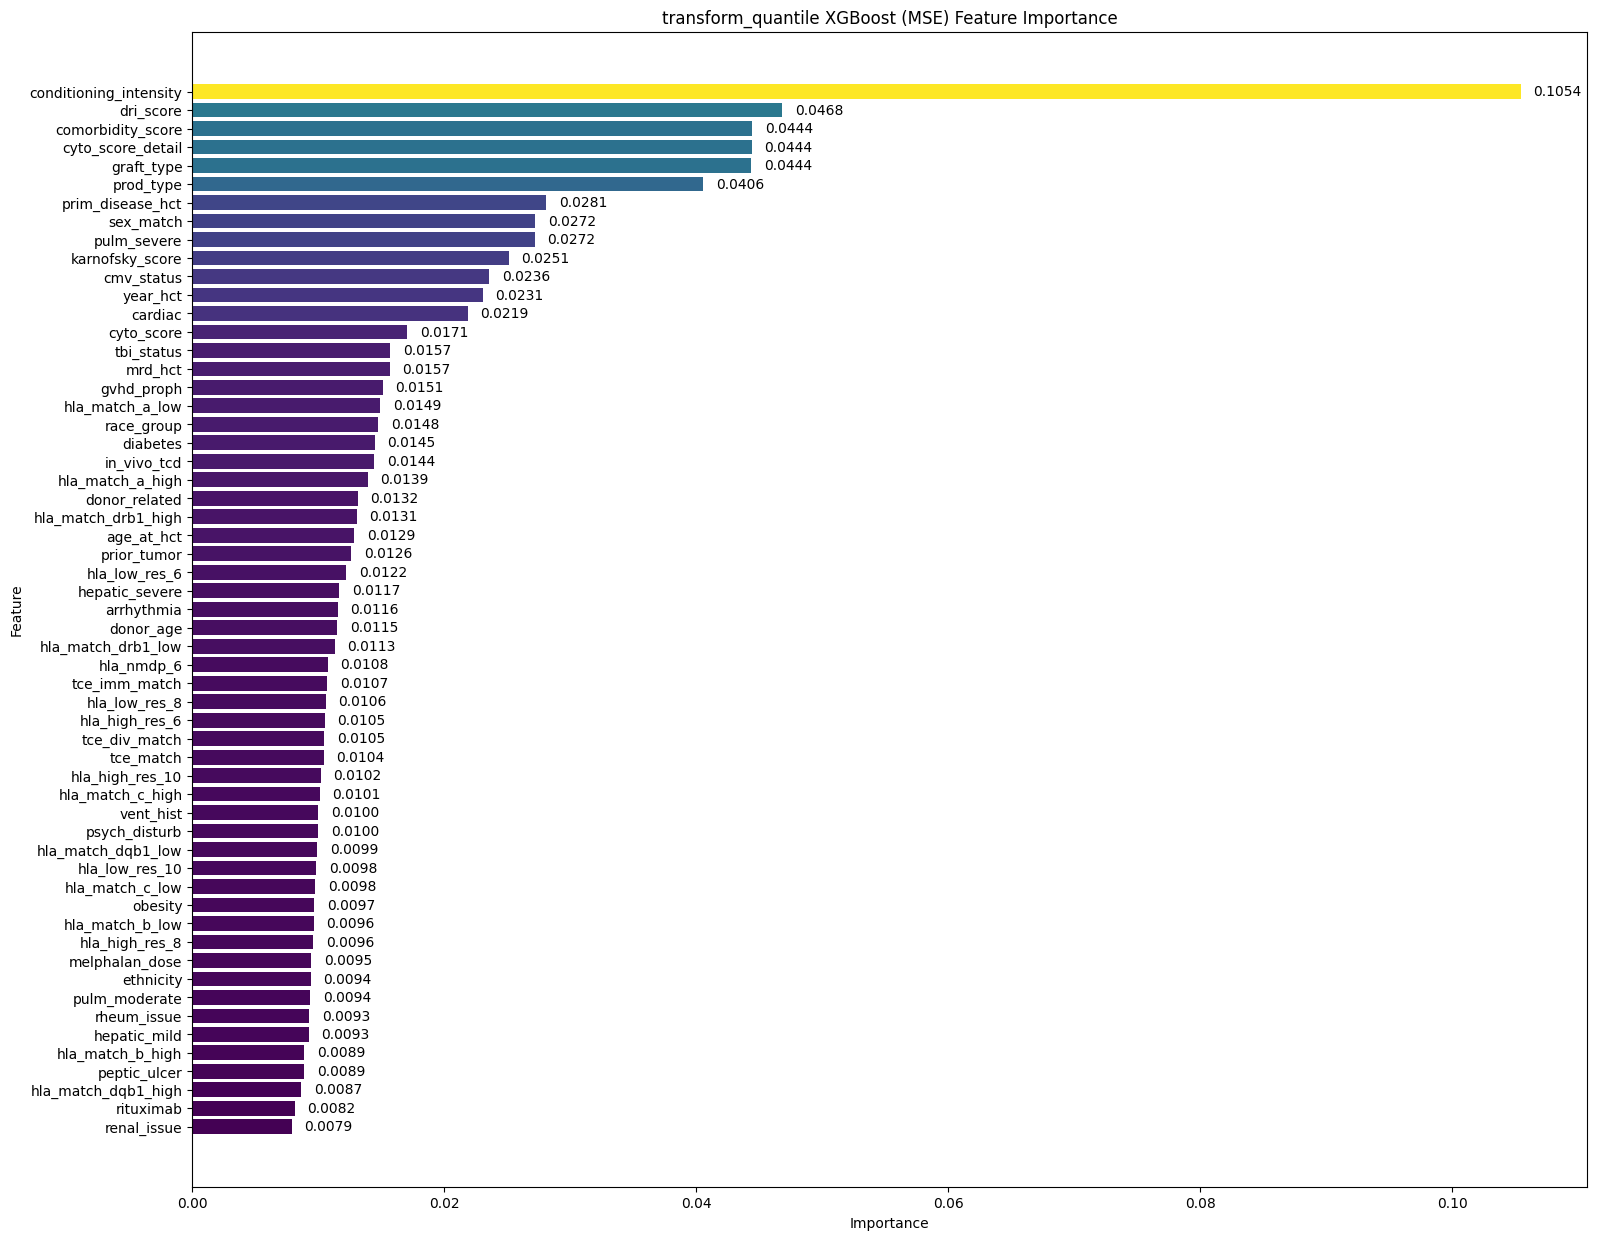

In [36]:
feature_importances = [model.feature_importances_ for model in all_model_data['models']['transform_quantile XGBoost (MSE)'].values()]

# Convert to numpy array and compute mean importance
feature_importances = np.array(feature_importances)
mean_importance = feature_importances.mean(axis=0)

# Create DataFrame for mean feature importance
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": mean_importance
}).sort_values(by="Importance", ascending=False)

# Normalize importance values for colormap
norm = plt.Normalize(importance_df["Importance"].min(), importance_df["Importance"].max())
colors = plt.cm.viridis(norm(importance_df["Importance"]))

plt.figure(figsize=(18, 15))
bars = plt.barh(importance_df["Feature"], importance_df["Importance"], color=colors)

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("transform_quantile XGBoost (MSE) Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability

# Add labels to each bar
for bar in bars:
    plt.text(
        bar.get_width() + 0.001,  # Position the text slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center the text vertically
        f"{bar.get_width():.4f}",  # Format the value
        va="center",  # Align vertically
        ha="left",  # Align horizontally
        fontsize=10
    )

plt.show()

These results make a lot of sense!  
The `conditioning_intensity` describes how a patient's body was prepared for HCT.  
Other top features include various scores (`dri_score`, `comorbidity_score`, etc.) that are given to patients to determine their health before HCT.  
It fits that they contribute the most to the score as they reflect the physical state the patient was in before HCT.

### Interpreting Feature Importance as an Alternative Modeling Insight

While we ultimately opted to retain the full feature set in our final model pipeline, the feature importance analysis still provides valuable interpretability. The XGBoost-based importance rankings reveal which variables most strongly influenced survival time predictions under the Accelerated Failure Time (AFT) objective.

These results can guide both clinical interpretation and future modeling strategies:
- Clinical relevance: Variables like age_at_hct, karnofsky_score, and comorbidity_score consistently appeared as top predictors. Their prominence reinforces their clinical significance in HCT outcomes, supporting their inclusion in downstream reporting or decision-making frameworks.
- Data quality checks: Some features with unexpectedly high or low importance scores prompted us to re-examine their distributions and missingness patterns. This process proved useful for flagging anomalies that might otherwise go unnoticed.
- Alternative modeling paths: Although not pursued here, one could imagine a model that performs feature selection based on importance scores. For example, retraining on the top-k features might yield a more compact model with minimal performance trade-off—a direction worth exploring in resource-constrained settings or for interpretability-focused applications.

Overall, this interpretive layer provides an important complement to model evaluation metrics. Even when not used to filter features, importance scores add transparency to the modeling process and may reveal patterns that statistical significance testing alone would miss.

### Improving the model

Most influential features identified:
- conditioning_intensity: How patient's body was prepared for HCT
- Various health scores (dri_score, comorbidity_score)
- HLA matching scores

Challenges affecting model performance:
1. Data Quality Issues:
   - Synthetic data artifacts (e.g. unnatural age distribution with 5 modes)
   - High number of missing values in important features
   - Possible information loss during data synthesis

2. Complex Medical Relationships:
   - Non-linear interactions between features
   - Time-dependent effects not captured
   - Medical conditions may have compound effects

3. Equity Challenges:
   - Model performs differently across race groups
   - Balancing accuracy with fairness
   - Synthetic data may not reflect real racial disparities

Potential Improvements:
1. Feature Engineering:
   - Create interaction terms between key features
   - Develop composite health scores
   - Better handling of missing values

2. Model Architecture:
   - Ensemble multiple models
   - Add regularization to prevent overfitting
   - Incorporate time-aware components

3. Fairness Optimization:
   - Race-specific model calibration
   - Balanced sampling strategies
   - Post-processing for equal odds

Note: The synthetic nature of the data remains a fundamental limitation,
as it may not fully capture the complexity of real medical relationships.

### Race group inequality
With most models, the Asian predictions get the highest scores (best concordance index) and the predictions for white patients get the lowest scores (worst concordance). 

As the competition's objective (equitability across diverse patient populations) rewards models with similar concordance scores for all six race groups,  
a possible strategy could be to artificially make the predictions for Asian patients worse.  

### Considered But Not Implemented: Alternative Modeling Strategies

While our primary modeling pipeline focused on optimizing XGBoost with the Cox Proportional Hazards objective and fairness-aware stratification, we also explored—but did not pursue—several additional directions that could offer potential value in future iterations.

#### Feature Importance as a Basis for Feature Selection

Our model revealed a subset of features with disproportionately high importance scores. These insights suggest that:
- **Model interpretability** could be enhanced by focusing analysis on top-ranked predictors.
- **Feature selection** (e.g., removing low-importance features) might simplify the model and reduce overfitting.

That said, we chose not to modify our final model pipeline based on this, as performance gains were not guaranteed, and our primary goal was to preserve robustness across diverse subgroups. Instead, we present feature importance as a **complementary analytical tool**, aiding interpretability rather than directly informing feature engineering in this version.

#### Advanced Modeling Techniques Not Pursued

Beyond XGBoost, we also considered exploring:
- **Ensemble methods** (e.g., stacking or blending multiple models),
- **Deep learning approaches** like survival neural networks,
- **Bayesian optimization** with uncertainty calibration.

However, these techniques require more complex infrastructure and tuning, and might compromise explainability — which is critical in healthcare settings. Thus, we opted for a more interpretable, well-supported model that aligns with the equity-oriented goals of the challenge.

#### Alternative Data Splitting Strategies

In this project, hyperparameter tuning and evaluation were performed via **k-fold cross-validation stratified by race group**. While effective for robustness, we also considered a **different approach**:
- Using **90% of the training data** for training  
- Holding out **10%** as a **fixed validation set** for hyperparameter tuning (e.g., via Optuna)

This method could offer:
- More stable tuning across a consistent validation set  
- A setup closer to real-world deployment workflows

We chose not to pursue it this time to avoid reducing training sample size, but it's a viable option for future pipelines, especially in ensemble modeling or when data volume increases.

---

These alternative paths offer promising directions for future refinement but were set aside in favor of a simpler, interpretable, and equitable modeling workflow in this phase.

### Understanding the Model’s Modest Performance

While our model demonstrates reasonable discrimination ability, it’s important to acknowledge that the overall performance—measured by metrics like the Concordance Index—is not particularly close to 1.0, even after tuning.

#### Why Aren’t the Results Closer to 1?

1. **Nature of Survival Data**  
   In post-HCT survival modeling, the outcomes are inherently noisy, multifactorial, and censored. Events can occur long after transplantation—or not at all—making exact prediction difficult even with rich feature sets.

2. **Synthetic or Engineered Dataset**  
   As noted earlier, the dataset used in this challenge has undergone some preprocessing or engineering. It may lack certain real-world complexities, or conversely, contain oversimplifications or artifacts that limit predictive signal. This can cap achievable model performance.

3. **Feature and Label Limitations**  
   - Some clinically meaningful variables may be missing, underrepresented, or approximated (e.g., disease stage granularity, treatment adherence).
   - Labels like `efs_time` reflect a mix of biological and institutional factors, making prediction inherently probabilistic.

4. **Modeling Bias Toward Fairness**  
   Our pipeline explicitly accounts for race group stratification to promote **equity** in modeling. While this improves subgroup fairness, it may slightly limit global optimization—trading off small performance gains for broader inclusion and fairness.

#### Relative Success: We're in the Ballpark

It’s also worth noting that:
> **Top-performing models in the official competition achieved metrics only slightly higher than ours.**

This suggests that:
- The problem itself is intrinsically hard.
- We've successfully captured much of the predictive signal available in the dataset.
- Further marginal improvements might require fundamentally different approaches (e.g., new data, additional clinical knowledge, or ensemble meta-modeling).

---

In short, while our results may not seem “high” in isolation, they are **competitive within this task’s landscape** and grounded in a principled, fairness-aware methodology.

## Final words

### Working environment
As we heard many disrecommendations for Kaggle notebooks as a work environment, we immediately skipped that option.

First we tried Google collab, but it proved difficult to work in,  
as the platform has bad intellisense, and no real realtime abillities.

We decided to switch to a rather newer option, Deepnote.  
It was easier to work there, due to having built in intellisense, realtime collaboration, and pretty UI.  
But for some reason, they made it really hard to work with text/markdown blocks.

We ended up working locally in VSCode by setting up a virtual environment,  
and using the Live Share extension for realtime collaboration.  
It wasn't super hard to set up, and is pretty easy to work with.  
So in the future, we will start with this option.

Beyond the technical choices and modeling challenges, this project served as an opportunity to reflect on what it means to build **fair, responsible, and interpretable machine learning models in healthcare**. Rather than focusing solely on marginal metric gains, we prioritized equity across demographic groups, transparent evaluation, and principled decision-making. This approach may not always lead to leaderboard dominance, but it lays a foundation for real-world impact and trustworthy science.

Throughout this journey, we’ve deepened not only our understanding of **data science and machine learning techniques**, but also of the **ethical dimensions of AI**. The experience reminded us that behind every data point is a patient — and that thoughtful modeling isn’t just about accuracy, but about responsibility. Questions of fairness, bias, and impact aren’t peripheral to our work as data scientists — they are central to doing it well.